### Operatioanal coverage estimator: model training

First, loading the sample

In [1]:
import numpy as np

y_sample=np.load("./y_samples.npy")
c=np.load("./c_samples.npy")
nominal_sample=np.load("./nominal_samples.npy")

#### High dimension
After loading the data, we can find the signal has a high dimension, which is much larger thena samplesize.

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# normalization
scaler0 =StandardScaler()
y_sample_s=scaler0.fit_transform(y_sample[1:])

# test signal d_{o}
yo=scaler0.transform(y_sample[0].reshape(1,-1))
# train signal d
ys=y_sample_s

print("the dimension of the signal",ys.shape[1],"is much larger than samplesize",ys.shape[0])


the dimension of the signal 65536 is much larger than samplesize 5000


### Dimension reduction

To reduce the complexity of the neural network and improve its efficiency. Here, we used  tensorflow structure to build an autoencoder to make dimension reduction since the dimension of predictor is higher than a sample size, and the high dimension of the signals lead to the unbalanced information between nominal level and signals in input space.

#### build the autoencoder with activation of tanh and relu
`tanh` is a smooth activation function and can deal with negative values, so we used it in the first layer of encoder. Since `relu` is more simple, so it was used in the remaining layers. Regulations were used to reduce overfitting in the first and second layers of encoder.

In [3]:
import tensorflow as tf
tf.random.set_seed(123)
from tensorflow import keras
from keras.layers import Dense
from keras import Input, Model, regularizers,optimizers

# Building the Input Layer
input_layer= Input(shape=(65536,))

# encoded representation of input
encoded1 = Dense(2048, activation='tanh',activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded2 = Dense(512, activation='relu',activity_regularizer=regularizers.l1(10e-5))(encoded1)
encoded3 = Dense(64, activation='relu')(encoded2)
encoded = Dense(8, activation='relu')(encoded3)


# decoded representation of code 
decoded3 = Dense(64, activation='relu')(encoded)
decoded2 = Dense(512, activation='relu')(decoded3)
decoded1 = Dense(2048, activation='relu')(decoded2)
decoded = Dense(65536, activation='relu')(decoded1)
# Model which take input image and shows decoded images
autoencoder = Model(input_layer, decoded)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65536)]           0         
_________________________________________________________________
dense (Dense)                (None, 2048)              134219776 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_5 (Dense)              (None, 512)               33280 

With larger dataset, `Adam` is more efficient and can combine the benefit of other two optimaizers: `AdaGrad` and `RMSprop`, which was used here.

In [4]:
#This model shows encoded signals
encoder = Model(input_layer, encoded)
# Creating a decoder model
encoded_input = Input(shape=(8,))
# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-4]
# decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
#optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001)

autoencoder.compile(optimizer=opt, loss='mse')

autoencoder.fit(ys, ys,
                epochs=3,
                batch_size=100,
                validation_split=0.05)

Epoch 1/3
48/48 [==============================] - 23s 440ms/step - loss: 1.1531 - val_loss: 1.1532
Epoch 2/3
48/48 [==============================] - 20s 425ms/step - loss: 1.1420 - val_loss: 1.1552
Epoch 3/3
48/48 [==============================] - 20s 420ms/step - loss: 1.1323 - val_loss: 1.1640


In [5]:
# encoding the sample signal ys and test signal yo
encoded_ys = encoder.predict(ys)
encoded_yo = encoder.predict(yo)

#### Adding nominal level as an input

In [6]:
# set test nominal level at 80%,85%,90%,95%
nominalo=np.array(np.arange(0.80,1,0.05))

# trainset build
encoded_yo_total = np.repeat(encoded_yo,4,axis=0)

scaler =StandardScaler() #normalization

y_sample=np.concatenate((nominal_sample.reshape(-1,1), encoded_ys),axis=1) 
ys_encoder_s=scaler.fit_transform(y_sample)

# test signal
y_acc0=np.concatenate((nominalo.reshape(-1,1),encoded_yo_total),axis=1)
yo_encoder_s=scaler.transform(y_acc0) #noramlization

### Classifier training
To make it simple, we used one-layer neural network with a sigmoid activation function here, actually, a logistic classifier.

In [7]:
# using sklearn to train classifier directly
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

clf = LogisticRegression().fit(ys_encoder_s, c)

### the realised operational coverage estimation for test signal with 80%,85%,90%,95% nominal levels
clf.predict_proba(yo_encoder_s)

array([[0.40923364, 0.59076636],
       [0.31717397, 0.68282603],
       [0.23749817, 0.76250183],
       [0.17277304, 0.82722696]])

#### another way to do logistic regression to ouput the estimation interval

In [8]:
import statsmodels.api as sm
X=sm.add_constant(ys_encoder_s)
cons=np.repeat(1.0,4)
Xo=np.concatenate((cons.reshape(-1,1),yo_encoder_s),axis=1)
# estimate the model
model = sm.Logit(c, X).fit()

proba=model.predict(Xo)
print(proba)

# estimation interval
# to estimate the prediction intercal, the delta method is applied to find approximate variance for predicted probability
# https://stackoverflow.com/questions/47414842/confidence-interval-of-probability-prediction-from-logistic-regression-statsmode
cov = model.cov_params()
gradient = (proba * (1 - proba) * Xo.T).T # matrix of gradients for each observation
# gradient is the vector of derivatives of predicted probability by model coefficients
# cov is the covariance matrix of coefficients
std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])
c = 1.96 # multiplier for confidence interval
upper = np.maximum(0, np.minimum(1, proba + std_errors * c))
lower = np.maximum(0, np.minimum(1, proba - std_errors * c))

print(upper)
print(lower)

Optimization terminated successfully.
         Current function value: 0.581121
         Iterations 5
[0.59063848 0.68280443 0.76256148 0.82733536]
[0.61810663 0.70176231 0.77995616 0.84629186]
[0.56317033 0.66384655 0.7451668  0.80837887]


In [9]:
import pickle
# save it to a file
with open('classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [14]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [15]:
np.save("./yo_encoder_s.npy",yo_encoder_s)

### The evaluation at the test signal $d_{o}$

([<matplotlib.axis.XTick at 0x7f84106c2278>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

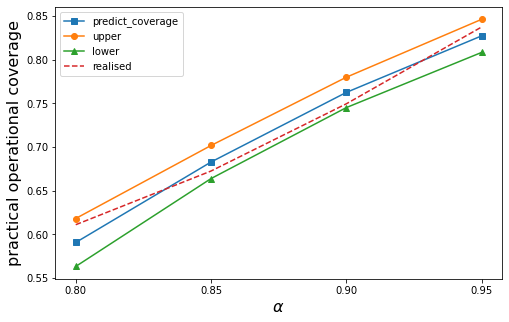

In [16]:
exact_ratio=np.load("./exact_ratio for test signal.npy")
# save the results
result=np.zeros((4,5))
result[:,0]=nominalo
result[:,1]=proba
result[:,2]=upper
result[:,3]=lower
result[:,4]=exact_ratio

import pandas as pd

df_do = pd.DataFrame(result, columns = ['nominal','predict_coverage','upper','lower','realised'])

plt.rcParams["figure.figsize"] = (8,5)
df_do.plot(x="nominal",style=['s-','o-','^-',"--"])
plt.ylabel('practical operational coverage',fontsize=16)
plt.xlabel(r"$\alpha$",fontsize=16)
plt.xticks([0.80,0.85,0.90,0.95])